# Google Trend Prediction

This notebook is created when learning PyTorch. I have used the Google Trend results for the word diet as my toy example.

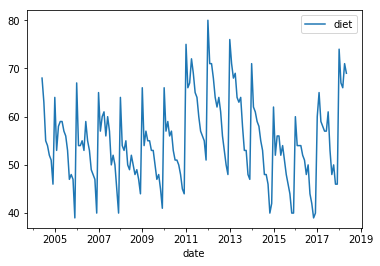

In [1]:
from pytrends.request import TrendReq
import pandas as pd
import matplotlib.pyplot as plt

keyword = 'diet'
pytrend = TrendReq(hl='de-CH')

# To dowloand it from internet, I have saved a local copy 
#pytrend.build_payload(kw_list=[keyword], timeframe='all')
#df = pytrend.interest_over_time()

df = pd.read_csv('./diet.csv', names=['date', 'diet'])
df = df[2:]
df.diet = df.diet.astype('int64')
df.date = pd.to_datetime(df.date)
df = df.set_index('date')
df2 = df[5:]

df2.plot()
plt.show()

We can observe the cylical nature of the dataset. Let's see how NNs will perform.

# Preprocessing

Preparing the data for NN

In [2]:
import pandas as pd
import numpy as np
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

lag = 5
pre_raw = df2.copy()

for i in range(1, lag+1):
    name = 'lag'+str(i)
    pre_raw.insert(loc=i, column = name, value = pre_raw.diet.shift(i))

pre_raw.insert(loc=lag+1, column= 'nextDay', value= pre_raw.diet.shift(-1))
pre_raw = pre_raw[lag:]
pre_raw = pre_raw[:-1]
pre_raw = pre_raw.reset_index(drop=True)
raw = pre_raw.iloc[:,0:lag+2].copy()
raw = [(torch.from_numpy(raw.iloc[i,0:lag+1].values), 
        torch.from_numpy(raw.iloc[i,[lag+1]].values)) for i in range(len(raw))]

# Models

In this notebook, I have explored a fully connected network and a convolutional network. To compare the results, I have created an experiment function which trains the model and evaluates its perfromance. I will repeat each experiment 30 times to minimize the impact of random initializations on the results.

In [3]:
class SimpleNet(nn.Module):
    def __init__(self, input_len=6):
        super().__init__()
        self.l1 = nn.Linear(input_len, 20)
        self.l2 = nn.Linear(20, 15)
        self.l3 = nn.Linear(15, 1)
        
    def forward(self, x):
        output = self.l1(x)
        output = F.relu(output)
        output = self.l2(output)
        output = F.relu(output)
        output = self.l3(output)
        return output

When using the input as it is, other activation functions (tanh, sigmoid) explode. Batchnorm has resolved this issue but the results are not better then this version. Hence it is not included.

In [4]:
class ConvNet(nn.Module):
    def __init__(self, layers, kernelSize = 5, stride=2):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv1d(layers[i], layers[i + 1], kernel_size=kernelSize, stride=stride)
            for i in range(len(layers) - 1)])
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.out = nn.Linear(layers[-1], 1)
        
    def forward(self, x):
        for l in self.layers: x = F.relu(l(x.unsqueeze_(-1).transpose(2, 1)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.out(x)

In [5]:
def experiment(lag, model, train_loader, test_loader, opt, loss):
    # train
    for epoch in range(num_epochs):
        running_loss = 0.0
        tot = 0
        for i, (x, y) in enumerate(train_loader):
            x = x.float().to(device)
            y = y.float().to(device)

            # Forward pass
            output = model(x)
            l = loss(output, y)

            # Backward and optimize
            opt.zero_grad()
            l.backward()
            opt.step()
        
            running_loss += l.item()
            tot += 1
        #print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss/tot  ))

    names = ['diet']
    names.extend(['lag'+str(i) for i in range(1, lag+1)])
    names.extend(['prediction', 'actual'])

    result = pd.DataFrame(columns=names)
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    with torch.no_grad():
        correct = 0
        total = 0
        for x, y in test_loader:
            x = x.float().to(device)
            local = x.cpu().numpy()
            y = y.float().to(device)            
            outputs = model(x)

            temp = pd.DataFrame(columns=names)
            temp['diet'] = local[:,0]
            for i in range(1, lag+1):
                name = 'lag'+str(i)
                temp[name] = local[:,i]

            temp['actual'] = y.cpu().numpy()
            temp['prediction'] = outputs.cpu().numpy()
            result = result.append(temp)
    return(result)        

In [6]:
num_epochs=20
batch_size=25
learning_rate=0.04
repeat = 30
results = pd.DataFrame(columns=['FC', 'CONV'])
train_loader = data.DataLoader(dataset=raw[0:120], batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(dataset=raw[120:170], batch_size=1, shuffle=False)

for i in range(repeat):
    temp = pd.DataFrame(columns=['FC', 'CONV'])
    
    net = SimpleNet(input_len=lag+1).to(device)
    opt=optim.Adam(net.parameters(), lr=learning_rate)
    loss=F.mse_loss
    
    out = experiment(lag= lag, 
               model=net, 
               train_loader=train_loader, 
               test_loader=test_loader, 
               opt=opt, 
               loss=loss)
    
    temp.loc[0] = [np.mean(abs(out.prediction - out.actual)), None]
    results = results.append(temp)

results = results.reset_index(drop=True);

In [7]:
num_epochs=20
batch_size=25
learning_rate=0.04
train_loader = data.DataLoader(dataset=raw[0:120], batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(dataset=raw[120:170], batch_size=1, shuffle=False)

for i in range(repeat):
    temp = pd.DataFrame(columns=['FC', 'CONV'])
    
    net = ConvNet([1, 10], kernelSize= 2, stride=2).to(device)
    opt=optim.Adam(net.parameters(), lr=learning_rate)
    loss=F.mse_loss
    
    out = experiment(lag= lag, 
               model=net, 
               train_loader=train_loader, 
               test_loader=test_loader, 
               opt=opt, 
               loss=loss)
    
    results.CONV[i] = np.mean(abs(out.prediction - out.actual))

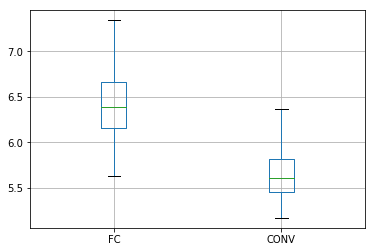

In [8]:
results.boxplot()
plt.show()

In [9]:
import scipy.stats
scipy.stats.ttest_ind(results.FC, results.CONV)

Ttest_indResult(statistic=8.0404990577837712, pvalue=5.2386641314794134e-11)

The t-test tells us the true mean of both results are statistically different and the boxplot visually confirms that this difference is better in terms of a lower RMSE. This result is not suprising because by using random convolutions we enhance the input space allowing the model to discover patterns that might not be easily learnable by a fully connected network.  

# Next Steps

In the next iteration of this notebook, I will look into following models/improvements:
* Recurrent Neural Networks (with and without LSTM)
* Enhance CNN using Residuals
* Incorporating embeddings into fully connected network to teach seasonal patterns